# Summary:
It is important to understand what type of loans have potential risks of default in order to help investors make informed decision to purchase Lending Club loans and to give the LC platform more confidence in loan underwriting. The key to finding out the loan default pattern is to understand the characteristics of the loan borrowers. 

In this notebook, I built two models - Random Forest and Gradient Boosting Trees in an effort to figure out the most important features of the borrowers that are potentially indicative of a high probability of loan default. 

Before building the model, the first half of the notebook covers all the data preprocessing, cleaning and feature engineering. The second part is about model building and evaluation, as well as feature importances extraction. 

The most important features selected by the model are borrowers' annual income, debt-to-income ratio, monthly installment and the credit history of revolving accounts/balance/utilization. Those indeed can tell us a lot about the borrowers creditibilities to pay back the loans.

Finally, I used the model that is trained on historical fully paid and default loans to predict on the loans with status "Current" to see which loans are likely to go default in the future. Given the distribution of predicted default probability, I choose a cut-off probability threshold of 0.32 to find the specific loan_IDs whose predicted probabilities are above the threshold, which means those loans are under potential risk of default. 

Investors can use the model predictions to understand the scale of risk in selected porfolio before they decide to purchase the loans, although some restrictions when applying the model in production should also be taken into account. There is some discussion about some concerns in the bottom part of this notebook, as I am not very familiar with the process how the loan dataset is generated.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [95]:
loan= pd.read_csv('lc_data_tape.csv')
payment = pd.read_csv('lc_payment_file.csv')

/Users/lalago31/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/lalago31/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (26,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 1. Check missing values & Inspect the columns

In [96]:
loan.isnull().sum()

id                                                 0
member_id                                     301057
loan_amnt                                          0
funded_amnt                                        0
funded_amnt_inv                                    0
term                                               0
int_rate                                           0
installment                                        0
grade                                              0
sub_grade                                          0
emp_title                                      19168
emp_length                                     17971
home_ownership                                     0
annual_inc                                         0
verification_status                                0
issue_d                                            0
loan_status                                        0
pymnt_plan                                         0
url                                           

In [97]:
loan.shape

(301057, 151)

In [98]:
loan.shape[0] - loan.isnull().sum() ## count of valid values in each column

id                                            301057
member_id                                          0
loan_amnt                                     301057
funded_amnt                                   301057
funded_amnt_inv                               301057
term                                          301057
int_rate                                      301057
installment                                   301057
grade                                         301057
sub_grade                                     301057
emp_title                                     281889
emp_length                                    283086
home_ownership                                301057
annual_inc                                    301057
verification_status                           301057
issue_d                                       301057
loan_status                                   301057
pymnt_plan                                    301057
url                                           

In [99]:
df=loan.copy()
df.dropna(axis=1,thresh=df.shape[0]*0.8,inplace=True) ## drop columns that contain less than 80% valid values.

In [100]:
df.shape

(301057, 93)

In [101]:
df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'a

In [102]:
df['emp_title'].value_counts()[:20]

Teacher               5074
Manager               4461
Owner                 2776
Registered Nurse      2105
RN                    2079
Supervisor            1911
Driver                1745
Sales                 1671
Project Manager       1460
Office Manager        1324
General Manager       1255
Director              1198
owner                 1131
President             1075
Engineer              1005
manager                980
teacher                942
Vice President         870
Operations Manager     830
Accountant             769
Name: emp_title, dtype: int64

In [103]:
df['pymnt_plan'].value_counts()

n    300981
y        76
Name: pymnt_plan, dtype: int64

In [104]:
df.disbursement_method.value_counts()

Cash         299924
DirectPay      1133
Name: disbursement_method, dtype: int64

In [105]:
df.application_type.value_counts()

Individual    292104
Joint App       8953
Name: application_type, dtype: int64

In [106]:
df.initial_list_status.value_counts()

w    188833
f    112224
Name: initial_list_status, dtype: int64

In [107]:
df.title.value_counts()

Debt consolidation                        152613
Credit card refinancing                    58056
Home improvement                           17962
Other                                      15754
Major purchase                              5757
Medical expenses                            3206
Debt Consolidation                          2738
Business                                    2733
Car financing                               2648
Vacation                                    1934
Moving and relocation                       1778
Home buying                                 1212
Consolidation                                891
debt consolidation                           787
Debt Consolidation Loan                      657
Credit Card Consolidation                    390
consolidation                                364
Personal Loan                                348
Home Improvement                             309
Consolidation Loan                           301
Credit Card Refinanc

In [108]:
delete_col=['out_prncp', 'total_pymnt','issue_d','url','zip_code','policy_code', 'id','emp_title','pymnt_plan',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int','debt_settlement_flag',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee','last_pymnt_d','last_credit_pull_d']

* columns like "id" or "url", "zip_code" borrower specific, excluding them because the goal of the prediction model is to find a general pattern of default.
* columns related to recovery and collection are deterministic- they only have values when the loan is already gone default. Since the goal is to find the potential default loan in order to prevent the loss from happening, including these columns will cause information leak. 

In [109]:
df2= pd.DataFrame(df , columns = [i for i in df.columns if i not in delete_col])

In [110]:
df2.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'purpose', 'title',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp_inv', 'last_pymnt_amnt',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'application_type', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'n

In [111]:
char_cols = df2.dtypes.pipe(lambda x: x[x == 'object']).index
num_cols= df2.dtypes.pipe(lambda x: x[x == 'float64']).index

In [112]:
df2[char_cols].head(20)

,term,int_rate,grade,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,title,addr_state,earliest_cr_line,revol_util,initial_list_status,application_type,hardship_flag,disbursement_method
0,36 months,9.91%,B,B1,2 years,MORTGAGE,Verified,Fully Paid,credit_card,No more credit card debt!,IL,Feb-2002,93.9%,f,Individual,N,Cash
1,60 months,16.77%,D,D2,2 years,RENT,Not Verified,Charged Off,other,Other,PA,Oct-2003,59.5%,f,Individual,N,Cash
2,36 months,15.96%,C,C5,7 years,RENT,Source Verified,Fully Paid,credit_card,Credit Card Loan,CA,Oct-2007,60.5%,f,Individual,N,Cash
3,36 months,18.25%,D,D5,9 years,MORTGAGE,Not Verified,Fully Paid,other,Year End Cleanup,PA,Sep-1998,98.1%,f,Individual,N,Cash
4,36 months,6.03%,A,A1,10+ years,MORTGAGE,Not Verified,Fully Paid,debt_consolidation,Debt-Consolidation,LA,Nov-1995,32.5%,f,Individual,N,Cash
5,36 months,10.65%,B,B2,6 years,RENT,Verified,Fully Paid,other,Other Loan,NY,Nov-2006,52.3%,f,Individual,N,Cash
6,60 months,17.27%,D,D3,6 years,RENT,Verified,Fully Paid,small_business,Start Up,CA,May-2006,58.9%,f,Individual,N,Cash
7,60 months,10.65%,B,B2,10+ years,RENT,Verified,Charged Off,debt_consolidation,Consolidation,OH,May-1997,30.1%,f,Individual,N,Cash
8,36 months,14.27%,C,C2,4 years,RENT,Source Verified,Fully Paid,debt_consolidation,New Start,CA,Oct-2002,83.4%,f,Individual,N,Cash
9,60 months,21.28%,F,F2,4 years,RENT,Source Verified,Charged Off,small_business,Small_Business Loan,CA,Jan-2000,73.9%,f,Individual,N,Cash


In [113]:
df2[num_cols].head(20)

,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,15000.0,15000.0,15000.0,483.38,92000.0,29.44,0.0,730.0,734.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,5000.0,5000.0,5000.0,123.65,50004.0,13.97,3.0,675.0,679.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,7000.0,7000.0,7000.0,245.97,34000.0,6.35,0.0,675.0,679.0,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
3,3000.0,3000.0,3000.0,108.84,65000.0,17.39,0.0,670.0,674.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
4,6000.0,6000.0,6000.0,182.62,45600.0,5.34,0.0,790.0,794.0,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
5,10000.0,10000.0,10000.0,325.74,27000.0,11.47,0.0,700.0,704.0,0.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
6,17500.0,8950.0,8925.0,223.74,40000.0,19.47,0.0,705.0,709.0,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
7,10000.0,10000.0,9975.0,215.69,45996.0,21.73,0.0,755.0,759.0,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
8,16425.0,16425.0,16425.0,563.53,44544.0,22.71,0.0,695.0,699.0,1.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
9,8200.0,8200.0,8200.0,223.14,75000.0,12.48,0.0,675.0,679.0,3.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


### 2. Feature Engineering

#### * convert revol_util and int_rate to numeric data type

In [114]:
df2['revol_util'] = df2['revol_util'].astype('str').apply(lambda x: float(x.strip('%'))).astype('float')

In [115]:
df2['int_rate'] = df2['int_rate'].astype('str').apply(lambda x: float(x.strip('%'))).astype('float')

#### * calculate credit history length = Month between "issue_d"  and  "earliest_cr_line"

In [116]:
pd.to_datetime(df['issue_d']).head()

0   2011-12-01
1   2011-12-01
2   2011-12-01
3   2011-12-01
4   2011-12-01
Name: issue_d, dtype: datetime64[ns]

In [117]:
import datetime as dt
from dateutil import relativedelta
df2['credit_length']= pd.to_datetime(df['issue_d']).dt.to_period('M') - pd.to_datetime(df2['earliest_cr_line']).dt.to_period('M')

In [118]:
df2['credit_length'] = df2['credit_length'].astype('int64')

#### * group "addr_state" into regions to decrease the levels of categorical variable

In [119]:
df2['addr_state'].unique()

array(['IL', 'PA', 'CA', 'LA', 'NY', 'OH', 'GA', 'TX', 'CO', 'KS', 'FL',
       'NJ', 'MD', 'DC', 'WA', 'WI', 'SD', 'VA', 'CT', 'MI', 'MA', 'AK',
       'HI', 'AZ', 'OK', 'NC', 'AL', 'MN', 'OR', 'SC', 'NV', 'RI', 'MO',
       'VT', 'NH', 'UT', 'AR', 'MT', 'KY', 'NM', 'WV', 'DE', 'TN', 'WY',
       'MS', 'ID', 'ME', 'IA', 'NE', 'IN', 'ND'], dtype=object)

In [120]:
# Make a list with each of the regions by state.
west = ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID']
south_west = ['AZ', 'TX', 'NM', 'OK']
south_east = ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ]
mid_west = ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND']
north_east = ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']

df2['Region'] = df2['addr_state'].apply(lambda x:'West' if x in west else "South West" if x in south_west else 'South East' if x in south_east\
                                       else 'Mid West' if x in mid_west else "North East")

In [121]:
df2[['Region','addr_state']].head()

,Region,addr_state
0,Mid West,IL
1,North East,PA
2,West,CA
3,North East,PA
4,South East,LA


In [122]:
df2[char_cols].isnull().sum()

term                       0
int_rate                   0
grade                      0
sub_grade                  0
emp_length             17971
home_ownership             0
verification_status        0
loan_status                0
purpose                    0
title                   3989
addr_state                 0
earliest_cr_line           4
revol_util               190
initial_list_status        0
application_type           0
hardship_flag              0
disbursement_method        0
dtype: int64

#### * label encoding emp_length since it has ordinal meaning, one-hot encoding will remove that layer of meaning

In [123]:
df2.emp_length.value_counts()

10+ years    100010
2 years       27217
< 1 year      25100
3 years       23785
1 year        19670
5 years       18590
4 years       17963
6 years       13840
8 years       12812
7 years       12771
9 years       11328
Name: emp_length, dtype: int64

In [124]:
df2['emp_length_num']= df2.emp_length.apply(lambda x: 10 if x=='10+ years' else 9 if x=='9 years' else 8 if x=='8 years'\
                                           else 7 if x=='7 years' else 6 if x=='6 years' else 5 if x=='5 years' \
                                            else 4 if x=='4 years' else 3 if x=='3 years' else 2 if x=='2 years' else 1)

#### * summarize loan_status into 3 levels

In [125]:
df2['loan_status'].value_counts()

Current                                                135530
Fully Paid                                             126622
Charged Off                                             32383
Late (31-120 days)                                       3544
In Grace Period                                          1424
Late (16-30 days)                                         992
Does not meet the credit policy. Status:Fully Paid        334
Does not meet the credit policy. Status:Charged Off       134
Default                                                    74
Issued                                                     20
Name: loan_status, dtype: int64

In [126]:
bad_loan = ["Charged Off", "Default", "In Grace Period", 'Does not meet the credit policy. Status:Charged Off'
            "Late (16-30 days)", "Late (31-120 days)"]
good_loan = ['Fully Paid','Does not meet the credit policy. Status:Fully Paid']

In [127]:
df2['loan_condition'] = df['loan_status'].apply(lambda x: 1 if x in bad_loan else 0 if x in good_loan else 2)

* 1= bad loan , 0=good loan, 2=current. Only 1 and 2 will be used in the model training to learn the general default loan pattern. 2 will be used for model prediction.

#### * apply one hot encoding to the rest of categorical features

In [128]:
char_cols = df2.dtypes.pipe(lambda x: x[x == 'object']).index
df2[char_cols].columns

Index(['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'purpose', 'title', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'application_type',
       'hardship_flag', 'disbursement_method', 'Region'],
      dtype='object')

In [129]:
df3=pd.get_dummies(df2.drop(['emp_length','loan_status','sub_grade','title','addr_state','earliest_cr_line','out_prncp_inv'],axis=1),drop_first=True)

In [130]:
df3.head()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,...,purpose_vacation,purpose_wedding,initial_list_status_w,application_type_Joint App,hardship_flag_Y,disbursement_method_DirectPay,Region_North East,Region_South East,Region_South West,Region_West
0,15000.0,15000.0,15000.0,9.91,483.38,92000.0,29.44,0.0,730.0,734.0,...,0,0,0,0,0,0,0,0,0,0
1,5000.0,5000.0,5000.0,16.77,123.65,50004.0,13.97,3.0,675.0,679.0,...,0,0,0,0,0,0,1,0,0,0
2,7000.0,7000.0,7000.0,15.96,245.97,34000.0,6.35,0.0,675.0,679.0,...,0,0,0,0,0,0,0,0,0,1
3,3000.0,3000.0,3000.0,18.25,108.84,65000.0,17.39,0.0,670.0,674.0,...,0,0,0,0,0,0,1,0,0,0
4,6000.0,6000.0,6000.0,6.03,182.62,45600.0,5.34,0.0,790.0,794.0,...,0,0,0,0,0,0,0,1,0,0


In [131]:
model_df = df3.loc[df3.loan_condition !=2,:] ## all loans but current ones
prediction_df = df3.loc[df3.loan_condition ==2,:] # current loans

In [132]:
model_df.to_csv('model_df.csv',header=True, index=False)
prediction_df.to_csv('prediction_df.csv',header=True, index=True)

Text(0.5,0.98,'Distribution of Loan Conditions')

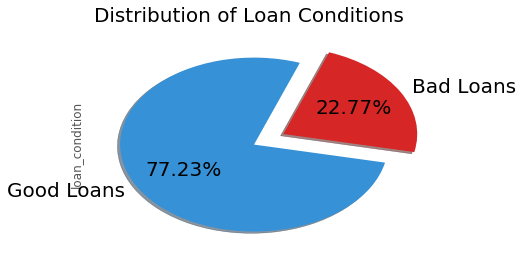

In [39]:
colors = ["#3791D7", "#D72626"]
labels ="Good Loans", "Bad Loans"

model_df["loan_condition"].value_counts().plot.pie(explode=[0,0.25], autopct='%1.2f%%', shadow=True, colors=colors, 
                                             labels=labels, fontsize=20, startangle=70)
plt.suptitle('Distribution of Loan Conditions', fontsize=20)


## 3. Build default prediction models

In [6]:
model_df =pd.read_csv('model_df.csv')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer

In [10]:
x_train,x_test,y_train,y_test = \
train_test_split(model_df.drop('loan_condition',axis=1),model_df['loan_condition'], test_size= 0.3)

In [11]:
x_train.shape

(115066, 96)

In [12]:
print(y_train.value_counts()/len(y_train))
print(y_test.value_counts()/len(y_test))

0    0.773095
1    0.226905
Name: loan_condition, dtype: float64
0    0.770536
1    0.229464
Name: loan_condition, dtype: float64


In [13]:
a = x_train.isnull().sum().sort_values(ascending=False)
x_train.isnull().sum()[a>0].sort_index()

acc_now_delinq                    2
acc_open_past_24mths           5843
avg_cur_bal                    8175
bc_open_to_buy                 6993
bc_util                        7072
chargeoff_within_12_mths         17
collections_12_mths_ex_med       17
delinq_2yrs                       2
delinq_amnt                       2
dti                               8
inq_last_6mths                    2
mo_sin_old_il_acct            11336
mo_sin_old_rev_tl_op           8172
mo_sin_rcnt_rev_tl_op          8172
mo_sin_rcnt_tl                 8172
mort_acc                       5843
mths_since_recent_bc           6909
mths_since_recent_inq         15881
num_accts_ever_120_pd          8172
num_actv_bc_tl                 8172
num_actv_rev_tl                8172
num_bc_sats                    6795
num_bc_tl                      8172
num_il_tl                      8172
num_op_rev_tl                  8172
num_rev_accts                  8172
num_rev_tl_bal_gt_0            8172
num_sats                    

In [159]:
#x_train.isnull().sum()[a==0].sort_index()

In [15]:
x_train.drop(['last_pymnt_amnt','last_fico_range_high','last_fico_range_low'],axis=1, inplace=True)
## these 3 features leak information about borrowers current payment and credit status, we won't be able to know this 
## in the stage when the loan is issued. 

#### Impute missing values

In [16]:
imr=Imputer(strategy='median',axis=0)#If axis=0, then impute along columns.
x_train_2 = imr.fit_transform(x_train)

### Random Forest Classifier

In [48]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [50]:
rf=RandomForestClassifier(oob_score=True)
params = {'n_estimators':[50,100], 'max_depth':[10,15],'min_samples_split': [8, 10, 12]}
grid_rf = GridSearchCV(rf, params , cv=4, n_jobs=-1)
grid_rf.fit(x_train_2,y_train)

GridSearchCV(cv=4, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 100], 'max_depth': [10, 15], 'min_samples_split': [8, 10, 12]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [51]:
grid_rf.best_params_

{'max_depth': 15, 'min_samples_split': 8, 'n_estimators': 100}

In [52]:
best_rf = grid_rf.best_estimator_

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
def model_performance (model, true_label, predicted_label):
    print(classification_report(true_label,predicted_label))
    print('roc_auc_score for '+ model +' model is {}'.format(roc_auc_score(true_label,predicted_label)))
    print('accuracy_score for '+ model +' model is {}'.format(accuracy_score(true_label,predicted_label)))
    print('recall_score for '+ model +' model is {}'.format(recall_score(true_label,predicted_label)))
    print(confusion_matrix(true_label,predicted_label))

#### Random Forest model performance report

In [54]:
model_performance('random forest' , y_train, best_rf.predict(x_train_2))

             precision    recall  f1-score   support

          0       0.83      1.00      0.91     88835
          1       0.99      0.30      0.46     26231

avg / total       0.87      0.84      0.81    115066

roc_auc_score for random forest model is 0.6508071662606943
accuracy_score for random forest model is 0.8404741626544766
recall_score for random forest model is 0.3021996873927795
[[88783    52]
 [18304  7927]]


(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
 <a list of 10 Text xticklabel objects>)

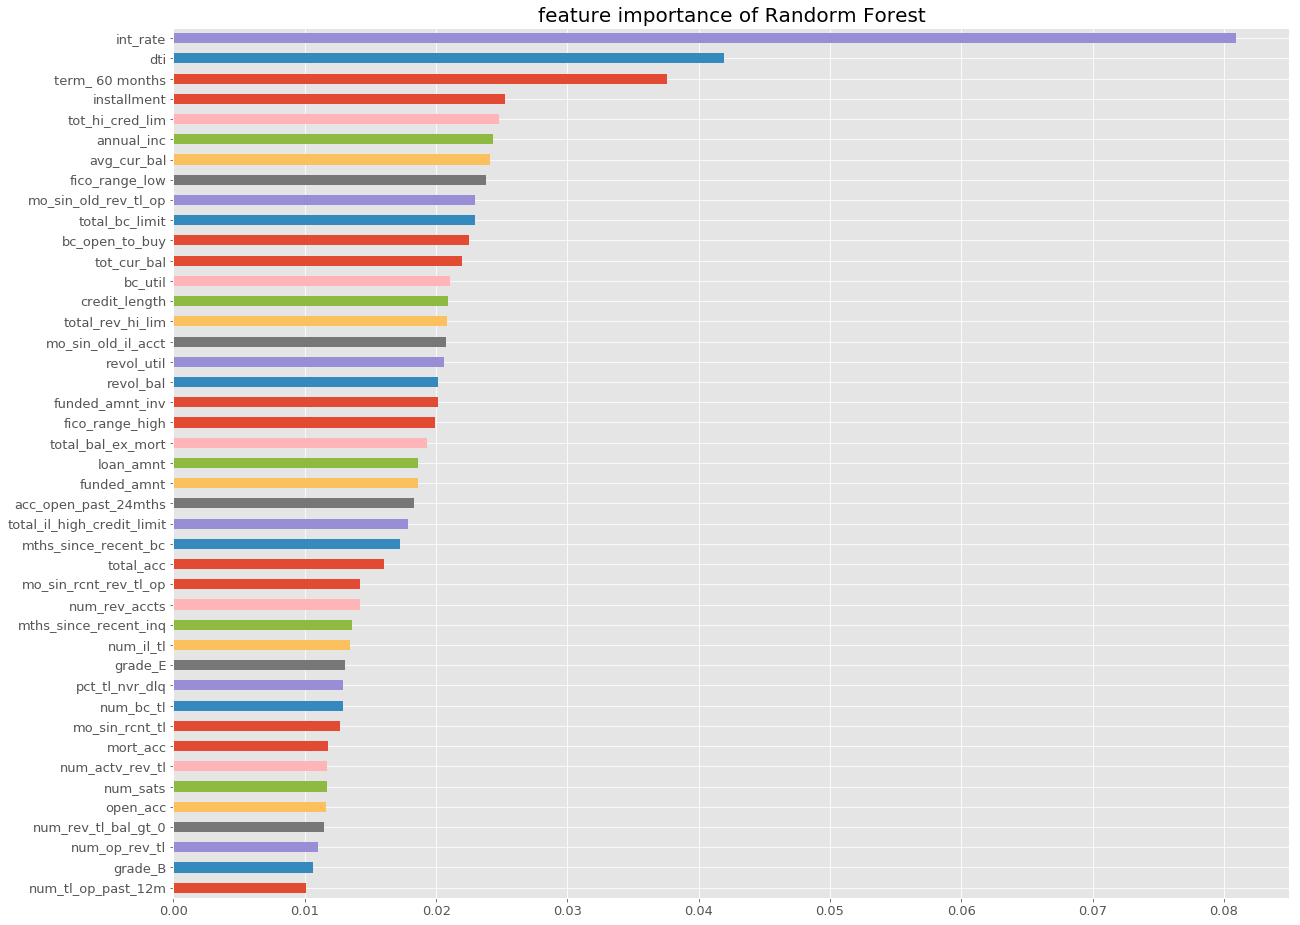

In [55]:
feature_importance=pd.Series(best_rf.feature_importances_ , index=x_train.columns).sort_values()
fig = plt.figure(figsize = (20,16));
feature_importance[50:].plot.barh()
plt.title('feature importance of Randorm Forest',fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

In [20]:
x_test.drop(['last_pymnt_amnt','last_fico_range_high','last_fico_range_low'],axis=1, inplace=True)
x_test_2= imr.transform(x_test)

In [21]:
#y_pred = best_rf.predict(x_test_2)
y_pred = np.where(best_rf.predict_proba(x_test_2)[:,1] > 0.3, 1, 0)
## change the decision threshold from probability 0.5 to 0.3

In [59]:
model_performance('random forest' , y_test, y_pred)

             precision    recall  f1-score   support

          0       0.84      0.81      0.82     38121
          1       0.42      0.48      0.45     11194

avg / total       0.75      0.73      0.74     49315

roc_auc_score for random forest model is 0.6428466235727386
accuracy_score for random forest model is 0.7331846294230964
recall_score for random forest model is 0.47739860639628373
[[30813  7308]
 [ 5850  5344]]


In [22]:
from sklearn.metrics import roc_curve
def plot_roc_curve(y_train,y_train_prob,y_test, y_test_prob, model):
    fpr, tpr, threshold = roc_curve(y_train, y_train_prob)
    fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_prob)
    roc_auc_train = auc(fpr, tpr)
    roc_auc_test = auc(fpr_test, tpr_test)
    
    #plot roc curve
    plt.figure()
    plt.title('Receiver Operating Characteristic of ' + model)
    plt.plot(fpr, tpr, 'b', label = 'Training AUC = %0.2f' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, 'r', label = 'Test AUC = %0.2f' % roc_auc_test)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([-0.05, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

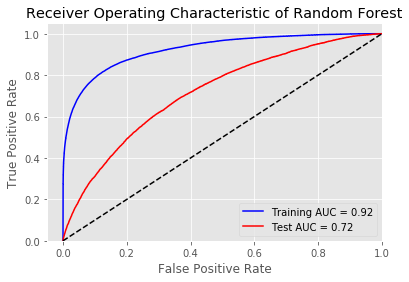

In [61]:
plot_roc_curve(y_train, best_rf.predict_proba(x_train_2)[:,1],\
    y_test, best_rf.predict_proba(x_test_2)[:,1],'Random Forest')

* Test set AUC is 0.2 lower than training set, indicating it's a little overfitting on the training set. The model parameters can be more finely tuned

### Gradient Boosting Tree Classifier

In [23]:
import xgboost as xgb
from xgboost import XGBClassifier

In [29]:
params = {'max_depth':12,'min_child_weight':3,'eta':0.1,\
          'subsample':0.8, 'colsample_bytree':0.8,'objective':'binary:logistic'}
Dtrain = xgb.DMatrix(x_train_2,y_train)
Dtest = xgb.DMatrix(x_test_2,y_test)
#xgbmodel= XGBClassifier(**params)
#grid_xgb = GridSearchCV(estimator=xgbmodel,param_grid =params, scoring='roc_auc', cv=4)

In [62]:
#grid_xgb.fit(x_train_2,y_train)
xgb.cv(params, Dtrain, num_boost_round=20,nfold=4,metrics=['auc','logloss'],early_stopping_rounds=5,verbose_eval=False)

,train-auc-mean,train-auc-std,train-logloss-mean,train-logloss-std,test-auc-mean,test-auc-std,test-logloss-mean,test-logloss-std
0,0.754568,0.002063,0.653525,0.000444,0.656697,0.003343,0.659414,0.000327
1,0.792451,0.002826,0.619695,0.000716,0.674792,0.004656,0.631476,0.000769
2,0.814305,0.002434,0.590477,0.000598,0.683387,0.004491,0.608420,0.001201
3,0.826668,0.003506,0.565591,0.000869,0.688050,0.004353,0.589260,0.001448
4,0.836697,0.002808,0.543988,0.000945,0.691762,0.004232,0.573097,0.001713
5,0.843978,0.003136,0.525174,0.000997,0.694876,0.004038,0.559490,0.001931
6,0.850382,0.002746,0.508502,0.001022,0.697027,0.004519,0.547978,0.002137
7,0.856154,0.001992,0.493774,0.000745,0.698538,0.004376,0.538364,0.002418
8,0.862501,0.001194,0.480411,0.000926,0.699993,0.004514,0.530166,0.002551
9,0.867913,0.001230,0.468432,0.000971,0.700846,0.004590,0.523273,0.002709


In [34]:
clf = xgb.XGBClassifier(**params)

clf.fit(x_train_2, y_train,
        eval_set=[(x_train_2, y_train), (x_test_2, y_test)],
        eval_metric=['auc','logloss'], verbose=False,
        early_stopping_rounds=4)

evals_result = clf.evals_result()

#### Distribution of predicted probability of default 

/Users/lalago31/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Predicted Probability of Default')

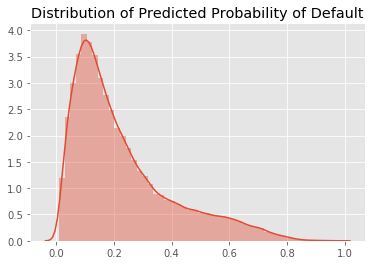

In [53]:
import seaborn as sns
sns.distplot(clf.predict_proba(x_train_2)[:,1], bins=50)
plt.title('Distribution of Predicted Probability of Default')

In [59]:
print('The 25% percentile of the probability of default is {}'.format(np.percentile(clf.predict_proba(x_train_2)[:,1],[25,50,75])[0]))
print('The 50% percentile of the probability of default is {}'.format(np.percentile(clf.predict_proba(x_train_2)[:,1],[25,50,75])[1]))
print('The 75% percentile of the probability of default is {}'.format(np.percentile(clf.predict_proba(x_train_2)[:,1],[25,50,75])[2]))

The 25% percentile of the probability of default is 0.10062437132000923
The 50% percentile of the probability of default is 0.17396390438079834
The 75% percentile of the probability of default is 0.3065590336918831


* notice that the distrition of loan condition chart above shows that 77% of the overall loan porfolio are good loans, about 23% are bad loans. So I'll choose the cut-off threshold to be the 75% percentile, which is 0.3 in probability

In [43]:
y_pred_xgb = np.where(clf.predict_proba(x_test_2)[:,1] > 0.3, 1, 0)

#### GBDT model performance report

In [44]:
model_performance('Gradient Boosting Tree' , y_test, y_pred_xgb)

             precision    recall  f1-score   support

          0       0.84      0.81      0.82     37999
          1       0.43      0.47      0.45     11316

avg / total       0.74      0.73      0.74     49315

roc_auc_score for Gradient Boosting Tree model is 0.6421282320865526
accuracy_score for Gradient Boosting Tree model is 0.7333265740646862
recall_score for Gradient Boosting Tree model is 0.4735772357723577
[[30805  7194]
 [ 5957  5359]]


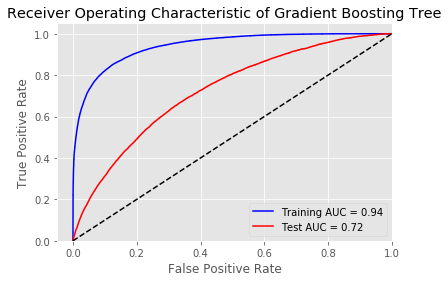

In [45]:
plot_roc_curve(y_train, clf.predict_proba(x_train_2)[:,1],\
    y_test, clf.predict_proba(x_test_2)[:,1],'Gradient Boosting Tree')

(array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]),
 <a list of 7 Text xticklabel objects>)

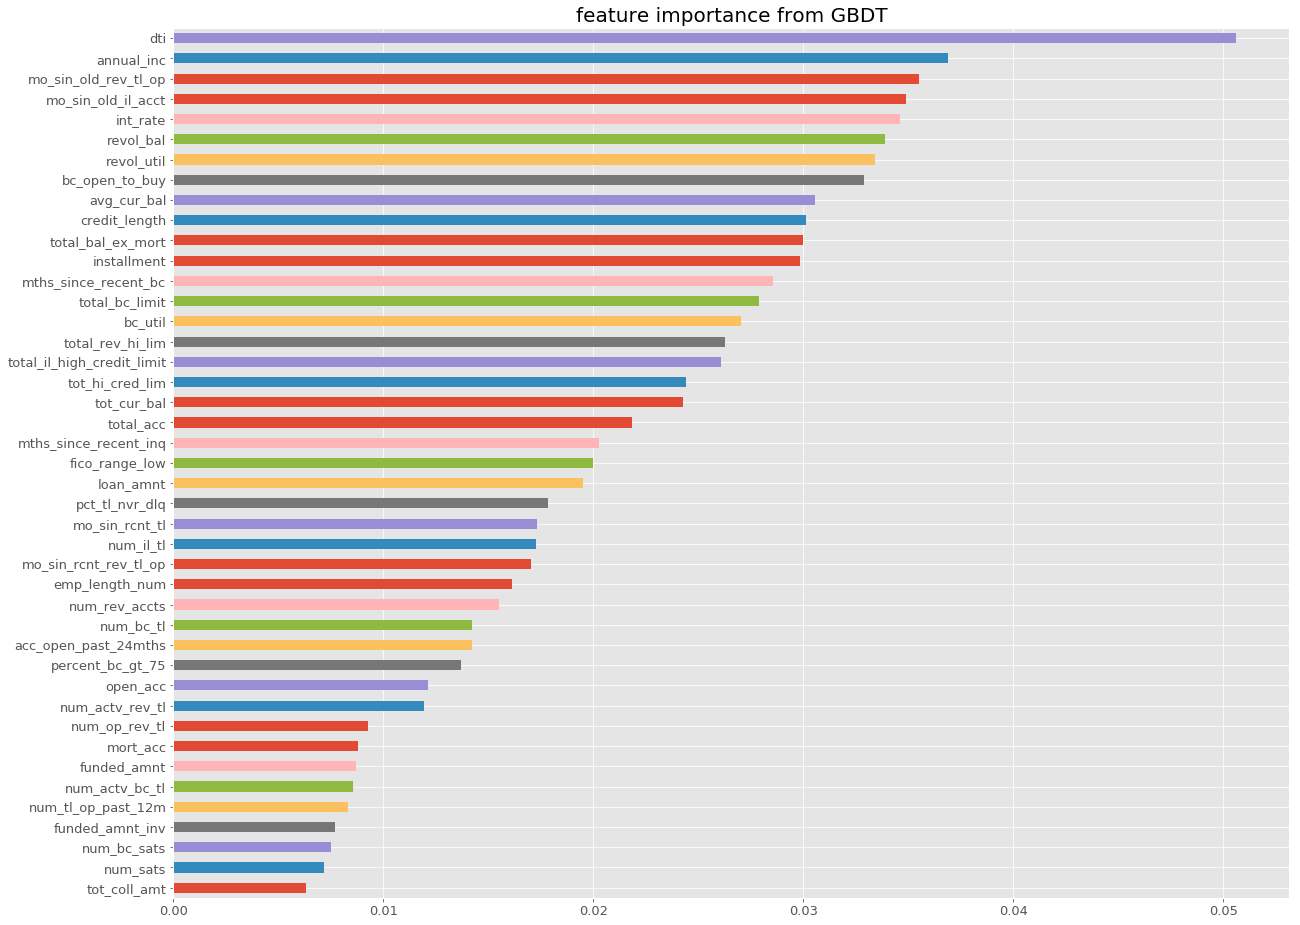

In [47]:
feature_importance=pd.Series(clf.feature_importances_ , index=x_train.columns).sort_values()
fig = plt.figure(figsize = (20,16));
feature_importance[50:].plot.barh()
plt.title('feature importance from GBDT',fontsize=20)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)

### Predict on the "Current" Loans to see which loans have high predicted probability of default

In [133]:
current_loan = pd.read_csv('prediction_df.csv')

In [140]:
current_loan = current_loan.set_index('Unnamed: 0')

In [149]:
current_loan.shape

(136676, 94)

In [135]:
current_loan.drop(['last_pymnt_amnt','last_fico_range_high','last_fico_range_low'],axis=1, inplace=True)

In [142]:
predict_df = current_loan.drop('loan_condition',axis=1).copy()

In [143]:
predict_df2 = imr.transform(predict_df)

In [144]:
pred_prob = clf.predict_proba(predict_df2)[:,1]

/Users/lalago31/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of Predicted Probability of Default on current loans')

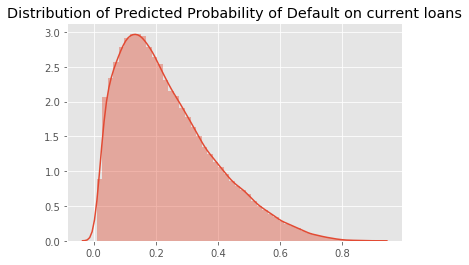

In [145]:
sns.distplot(pred_prob, bins=50)
plt.title('Distribution of Predicted Probability of Default on current loans')

In [146]:
print('The 25% percentile of the probability of default is {}'.format(np.percentile(pred_prob,[25,50,75])[0]))
print('The 50% percentile of the probability of default is {}'.format(np.percentile(pred_prob,[25,50,75])[1]))
print('The 75% percentile of the probability of default is {}'.format(np.percentile(pred_prob,[25,50,75])[2]))

The 25% percentile of the probability of default is 0.11919893696904182
The 50% percentile of the probability of default is 0.20666834712028503
The 75% percentile of the probability of default is 0.32866740226745605


In [150]:
current_loan['predicted_default_probability'] = pred_prob
potential_bad_loans = current_loan.loc[current_loan['predicted_default_probability']>0.32,:]

In [158]:
print('There are %d loans with the status "current" that have a high probability of default' %potential_bad_loans.shape[0])
print('The sample "risky" loan ids are \n{}'.format(potential_bad_loans.index.values[:200]))

There are 36039 loans with the status "current" that have a high probability of default
The sample "risky" loan ids are 
[ 6906  7047  7322  7349  7371  7383  7440  7469  7519  7642  7651  7758
  7808  7845  7852  7860  7864  7873  7874  7876  7885  7889  7944  7997
  8079  8220  8297  8313  8316  8321  8345  8367  8434  8438  8457  8475
  8525  8541  8579  8586  8604  8711  8809  8981  9020  9030  9049  9052
  9058  9081  9082  9160  9203  9208  9239  9244  9246  9256  9301  9310
  9381  9392  9400  9408  9412  9491  9605  9634  9688  9692  9709  9800
  9809  9813  9906  9922  9993  9996 10021 10047 10048 10066 10067 10147
 10160 10237 10443 10472 10485 10548 10569 10590 10676 10756 10791 10827
 10887 10892 10964 10975 10991 11056 11121 11158 11172 11181 11197 11339
 11353 11360 11367 11425 11427 11436 11452 11554 11556 11567 11615 11656
 11722 11734 11752 11754 11759 11796 11873 11965 11972 11978 12048 12067
 12068 12173 12228 12238 12246 12301 12302 12311 12340 12379 12438 12496
 12

### ** Insights:
1. Interest rate is the most important feature in predicting loan default, followed by debt-to-income ratio, monthly payment(installment) and borrowers' annual income. This indeed match our initial expectation in the EDA.
2. Credit length and many other features related to bankcard revolving accounts/utilization/balance of the borrowers tell a lot about the borrowers' credibility to pay back the loan
3. Most of the top 40 important features can be obtained from credit credit buearus. The public credit history together with the borrowers demographic info such as self-reported income can be fed into the ML algrithm beforehand to predict the probability of default. That can be used to decide if the loan should be issued in the very beginning and to help investors understand the risk of the loan porfolio in order for them to make informed decisions. 

### ** Restrictions:
I believe the dataset is updated quarterly to reflect the most up-to-date loan status. So the information that the investors see when the loan goes through the underwriting process might be different from what's now in the dataset. For example, I'm not sure whether some important information such as interest_rate, dti and installment is available to the investors before they decide to purchase the loans, or it is only generated after the loans are issued. If the latter is true, the model will have to be changed to only utilize the features that are available to investors in their decision making stage.